# Introduction


#### Dataset
Berisi mengenai tweet pada Olimpiade Tokyo 2021

#### Sumber Dataset
Data berasal dari Kaggle dengan link: https://www.kaggle.com/amritpal333/tokyo-olympics-2021-tweets?select=Olympics_Tokyo_tweets.csv

#### Objectivity
Membuat Sentimen Analysis terhadap text tweeter pada olimpiade 2021 dengan Algoritma LSTM

# Import Pustaka

In [89]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import os
import re
import string
import nltk
import random
import gensim
nltk.download('stopwords')
from tensorflow import keras
from textblob import TextBlob
from wordcloud import WordCloud
from nltk.corpus import stopwords
from collections import Counter
from gensim.models import Word2Vec

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from keras.preprocessing.text import Tokenizer
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Loading

In [91]:
df = pd.read_csv('/content/drive/MyDrive/milestone2/Olympics_Tokyo_tweets.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,4,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### melihat data teratas

In [92]:
df.head()

,id,text,user_screen_name,user_location,retweet_count,favorited,favorite_count,user_description,user_created_at,user_followers,user_friends,date,language
0,1419334065375924227,Rejected sports for the 2020 Olympics include ...,tbelmontedu,New Jersey,0,False,0,High School Language Arts Teacher. Technology ...,2013-01-21 00:03:31,778.0,661,2021-07-25 16:29:45,en
1,1419334059424043009,Why is the Team USA men basketball team playin...,silverchasm,"Lynwood, CA",0,False,0,bleh,2014-05-13 18:54:40,66.0,553,2021-07-25 16:29:44,en
2,1419334056161030146,@my_hive_away I'm watching kayaking on the Oly...,cshaw12897514,NaN,0,False,0,"not much to say, not very interesting. but I'm...",2020-10-19 14:15:06,494.0,757,2021-07-25 16:29:43,en
3,1419334052876795905,While girls her age are still trying to figuri...,AdultMediaTV,United States,0,False,0,Design | Photography | Film 18+ Test ready\nIn...,2015-08-18 22:33:39,19.0,3,2021-07-25 16:29:42,en
4,1419334052180594699,@omensfromeden patty mills is at the Olympics???,muddyfoxglove,hozier.tamino.florence.etc.,0,False,0,what if i was a bog body and you were a bog bo...,2016-11-20 06:02:11,1153.0,622,2021-07-25 16:29:42,en


#### Melihat shape data

In [93]:
df.shape

(312825, 13)

data terdiri dari 13 columns dan 312825 rows

#### Melihat statistika data

In [94]:
df.describe()

,user_followers
count,3.127950e+05
mean,8.878023e+04
std,1.184703e+06
min,0.000000e+00
25%,1.130000e+02
50%,4.740000e+02
75%,2.048000e+03
max,7.806182e+07


#### Melihat columns data

In [95]:
df.columns

Index(['id', 'text', 'user_screen_name', 'user_location', 'retweet_count',
       'favorited', 'favorite_count', 'user_description', 'user_created_at',
       'user_followers', 'user_friends', 'date', 'language'],
      dtype='object')

# Data Cleaning

#### Membuat dataset baru

In [96]:
dataset = pd.DataFrame(df['text'].values, columns=['tweets'])
dataset

,tweets
0,Rejected sports for the 2020 Olympics include ...
1,Why is the Team USA men basketball team playin...
2,@my_hive_away I'm watching kayaking on the Oly...
3,While girls her age are still trying to figuri...
4,@omensfromeden patty mills is at the Olympics???
...,...
312820,This artistic swimming is unreal. #Olympics
312821,@fZaq6zCW8aVobP5 @Noormehr_Javan @Olympics @wo...
312822,finally someone said it!\n@__ashutosh___ \ndif...
312823,@hnonoo75 @Olympics @BahrainOlympic Congratula...


Dataset baru hanya mengambil feature tweets untuk dilakukan proses sentiment analysis

#### Melakukan pengecekan missing values

In [97]:
dataset.isna().sum()

tweets    4
dtype: int64

terdapat 4 missing values pada features tweets

#### Mengatasi missing values

In [98]:
dataset.dropna(inplace=True)
dataset.isna().sum()

tweets    0
dtype: int64

melakukan penghapusan data untuk mengatasi missing values

#### Melakukan pembersihan text

In [99]:
def remove_url(text):
  url = re.compile(r"https?://\S+|www\.\S+")
  return url.sub(r"", text)

def remove_html(text):
  html = re.compile(r"<.*?>")
  return html.sub(r"", text)

def remove_num(text):
  text = re.sub(r"@[A-Za-z0-9]+", '', text)
  return text

def remove_emoji(string):
  emoji_pattern = re.compile(
      "["
      u"\U0001F600-\U0001F64F" #Emoticons
      u"\U0001F300-\U0001F5FF" #symbols & picture
      u"\U0001F680-\U0001F6FF" #transport & map symbols
      u"\U0001F1E0-\U0001F1FF" # flags(iOS)
      u"\U00002702-\U00002780"
      u"\U000024C2-\U0001F251"
      "]+",
      flags=re.UNICODE,
  )
  return emoji_pattern.sub(r"", string)

def remove_punct(text):
  table = str.maketrans("","", string.punctuation)
  return text.translate(table)

In [100]:
dataset['tweets'] = dataset['tweets'].map(lambda x: remove_url(x))
dataset['tweets'] = dataset['tweets'].map(lambda x: remove_html(x))
dataset['tweets'] = dataset['tweets'].map(lambda x: remove_emoji(x))
dataset['tweets'] = dataset['tweets'].map(lambda x: remove_punct(x))
dataset['tweets'] = dataset['tweets'].apply(remove_num)

melakukan pembersihan untuk menghilangkan url, html, number, emoji dan punctuation pada features tweets

#### Menghilangkan stopwords

In [101]:
stop = set(stopwords.words('english'))


def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    
    return " ".join(text)

In [102]:
dataset['tweets'] = dataset['tweets'].map(remove_stopwords)

Stop word adalah kata yang umum digunakan (seperti “the”, “a”, “an”, “in”) yang telah diprogram untuk diabaikan oleh search engine,
untuk itu Kita akan menghapus stopwords sesuai dengan yang tersimpan dalam corpus nltk untuk mempercepat waktu pemrosesan. 

#### Membuat function untuk Subjektivitas

In [103]:
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

subjectivity untuk melihat value dari tweet itu adalah opini atau faktual

#### Membuat function untuk Polarity

In [104]:
def getPolarity(text):
  return TextBlob(text).sentiment.polarity

Polarity digunakan untuk melihat seberapa positif atau negatif sebuah teks

#### Membuat Feature baru yaitu Subjectivity dan Polarity

In [105]:
dataset['Subjectivity'] = dataset['tweets'].apply(getSubjectivity)
dataset['Polarity'] = dataset['tweets'].apply(getPolarity)

#### Melihat dataset baru

In [106]:
dataset

,tweets,Subjectivity,Polarity
0,rejected sports 2020 olympics include bowling ...,0.000000,0.000000
1,team usa men basketball team playing horrible ...,1.000000,-0.450000
2,myhiveaway im watching kayaking olympics broad...,0.575000,0.375000
3,girls age still trying figuring open account o...,0.350000,0.050000
4,omensfromeden patty mills olympics,0.000000,0.000000
...,...,...,...
312820,artistic swimming unreal olympics,1.000000,0.333333
312821,fzaq6zcw8avobp5 noormehrjavan olympics worldka...,0.000000,0.000000
312822,finally someone said ashutosh difference pseud...,0.533333,0.133333
312823,hnonoo75 olympics bahrainolympic congratulatio...,0.000000,0.000000


#### Membuat function untuk melakukan pemisahan sentimen negative, neutral, and positive analysis

In [107]:
def getScore(score):
  if score < 0:
    return 'negative'
  elif score == 0:
    return "neutral"
  else:
    return "positive"

membuat function getScore untuk membuat klasifikasi tweets Negative, Neutral, dan Positive

#### Membuat Features Label

In [108]:
dataset['Label'] = dataset['Polarity'].apply(getScore)

In [109]:
dataset

,tweets,Subjectivity,Polarity,Label
0,rejected sports 2020 olympics include bowling ...,0.000000,0.000000,neutral
1,team usa men basketball team playing horrible ...,1.000000,-0.450000,negative
2,myhiveaway im watching kayaking olympics broad...,0.575000,0.375000,positive
3,girls age still trying figuring open account o...,0.350000,0.050000,positive
4,omensfromeden patty mills olympics,0.000000,0.000000,neutral
...,...,...,...,...
312820,artistic swimming unreal olympics,1.000000,0.333333,positive
312821,fzaq6zcw8avobp5 noormehrjavan olympics worldka...,0.000000,0.000000,neutral
312822,finally someone said ashutosh difference pseud...,0.533333,0.133333,positive
312823,hnonoo75 olympics bahrainolympic congratulatio...,0.000000,0.000000,neutral


Membuat features Label yang valuesnya adalah klasifikasi tweets Negative, Neutral, dan Positive 

# Exploratory Data Analysis

#### Melakukan visualisasi word cloud

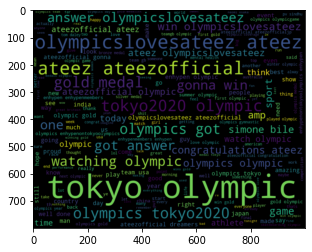

In [110]:
allWords = ' '.join([twts for twts in dataset['tweets']])
WordCloud = WordCloud(width=1000, height=800, random_state=20, max_font_size= 119).generate(allWords)

plt.imshow(WordCloud, interpolation='bilinear')

Dari visualisasi terlihat bahwa kata 'Tokyo' dan 'Olympic' adalah kata yang sering muncul

#### Persentase Positive tweets

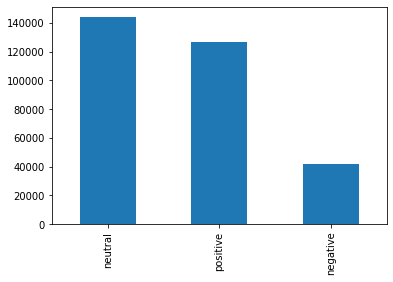

In [111]:
dataset.Label.value_counts().plot(kind='bar');

In [112]:
positive_tweet = dataset[dataset.Label == 'positive']['tweets']
neutral_tweet = dataset[dataset.Label == 'neutral']['tweets']
negative_tweet = dataset[dataset.Label == 'negative']['tweets']
print('Persentase Positive tweets = ',round((positive_tweet.shape[0] / dataset.shape[0])*100 ,2))
print('Persentase Neutral tweets = ',round((neutral_tweet.shape[0] / dataset.shape[0])*100 ,2))
print('Persentase Negative tweets = ',round((negative_tweet.shape[0] / dataset.shape[0])*100 ,2))

Persentase Positive tweets =  40.56
Persentase Neutral tweets =  46.04
Persentase Negative tweets =  13.4


#### Melihat Label tweets positive, neutral, dan negative

In [113]:
random_index = random.randint(0, len(dataset)-5)

for row in dataset[["tweets", "Label"]][random_index:random_index+5].itertuples():
  _, text, target = row
  if target == "positive":
    print(f"Target: {target} (positive)")
  elif target == "neutral":
    print(f"Target: {target} (neutral)")
  else:
    print(f"Target: {target} (negative)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: neutral (neutral)
Text:
geraint thomas saw wheels come tour de france tokyo olympics hes contr…

---

Target: neutral (neutral)
Text:
case missed simonebiles still struggling tokyo 2020 event finals horizon…

---

Target: positive (positive)
Text:
imagine comments media nadal couldnt win gold medal olympics held clay

---

Target: neutral (neutral)
Text:
gonna go cry equalise gbrvaus wearematildas olympics

---

Target: neutral (neutral)
Text:
fridays show russellwestbrook lakeshow yankees rizzoforever nbadraft2021 olympics sunileegold usa…

---



# Feature Engineering

#### Mengubah Categorical menjadi numerical pada features Label

In [114]:
label_mapping = { k: i for i, k in enumerate(dataset['Label'].unique(), 0)}
label_mapping

{'negative': 1, 'neutral': 0, 'positive': 2}

In [115]:
dataset['Label'] = dataset['Label'].map(label_mapping)

In [116]:
dataset

,tweets,Subjectivity,Polarity,Label
0,rejected sports 2020 olympics include bowling ...,0.000000,0.000000,0
1,team usa men basketball team playing horrible ...,1.000000,-0.450000,1
2,myhiveaway im watching kayaking olympics broad...,0.575000,0.375000,2
3,girls age still trying figuring open account o...,0.350000,0.050000,2
4,omensfromeden patty mills olympics,0.000000,0.000000,0
...,...,...,...,...
312820,artistic swimming unreal olympics,1.000000,0.333333,2
312821,fzaq6zcw8avobp5 noormehrjavan olympics worldka...,0.000000,0.000000,0
312822,finally someone said ashutosh difference pseud...,0.533333,0.133333,2
312823,hnonoo75 olympics bahrainolympic congratulatio...,0.000000,0.000000,0


In [117]:
train_dataset, test_dataset = train_test_split(dataset, test_size=0.10)

untuk menghindari adanya kemungkinan kebocoran data sehingga kita perlu membagi data terlebih dahulu dan kemudian menerapkan fitur engineering

In [118]:
print(f"Total training samples: {len(train_dataset)}")
print(f"Total test samples: {len(test_dataset)}")
print(f"Total samples: {len(train_dataset) + len(test_dataset)}")

Total training samples: 281538
Total test samples: 31283
Total samples: 312821


In [119]:
train_dataset

,tweets,Subjectivity,Polarity,Label
30078,dis bull sign olympics,0.000000,0.000,0
65533,bruh guys swimming thru sewage water national ...,0.000000,0.000,0
256838,adegoke moving 100m heat heh olympics,0.000000,0.000,0
63920,deserves nowhere near competitive anything let...,0.400000,0.100,2
77132,jadecarey018 robbed cheated excellent job stuc...,1.000000,1.000,2
...,...,...,...,...
256537,athieng mu nyan deng lemon nyan aluel south su...,1.000000,0.800,2
119106,olympics worldrugby7s obvoius🤸🤸fiji give newzz...,0.000000,0.000,0
271146,sweeeeep di tingsssss 🥇🥈🥉 jamaica teamjamaica ...,0.000000,0.000,0
193681,sindhu draws first blood takes first game comf...,0.466667,0.125,2


In [120]:
test_dataset

,tweets,Subjectivity,Polarity,Label
20615,olympics streaming bts world tracks,0.000000,0.000000,0
5420,toeonfronthalf thinking l10 turned elite vault...,0.000000,0.000000,0
286364,billionaire foreign planet ever lands earth ta...,0.125000,-0.125000,1
78541,people say sex mental construct amp trans athl...,0.516667,0.200000,2
179081,childhood memories olympics coincided successe...,0.000000,0.000000,0
...,...,...,...,...
255591,gravity calling baseball loss confidence known...,0.500000,0.000000,0
109153,i’m excited nervous watch event tokyo2020 olym...,0.750000,0.375000,2
84426,ps2sday im sharing recent pick athens 2004 fol...,0.175000,0.000000,0
184844,strength determination fijiana team far bloody...,0.966667,-0.066667,1


### Data Preprocessing

#### Menyiapkan target

In [121]:
X_train, y_train = train_dataset.tweets, train_dataset.Label
X_test, y_test = test_dataset.tweets, test_dataset.Label

In [122]:
def prepare_targets(y_train, y_test):
    y_train_enc = to_categorical(y_train)
    y_test_enc = to_categorical(y_test)
    return y_train_enc, y_test_enc

y_train, y_test = prepare_targets(y_train, y_test)

In [123]:
y_train

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

#### Melakukan Split data

In [124]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(X_train.to_numpy(),
                                                                            y_train,
                                                                            test_size=0.2,
                                                                            random_state=42)

#### Pipeline

#### Membangun Pipeline

In [125]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "data"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [126]:
def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    churn_dir = os.path.join("datasets", "tweets")
    os.makedirs(churn_dir, exist_ok=True)
    path_format = os.path.join(churn_dir, "my_{}_{:02d}.csv")

    filepaths = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        with open(part_csv, "wt", encoding="utf-8") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

In [127]:
train_data = np.c_[train_sentences, train_labels]
valid_data = np.c_[val_sentences, val_labels]
header_cols = dataset.columns 
header = ",".join(header_cols)

In [128]:
train_filepaths = save_to_multiple_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_multiple_csv_files(valid_data, "valid", header, n_parts=10)

### Train dataset

In [129]:
pd.read_csv(train_filepaths[0]).head()

,tweets,Subjectivity,Polarity,Label
0,'usa vs czech republic score results kevin dur...,1.0,0.0,0.0
1,'daily tokyo olympics 2020 recap team canada w...,0.0,0.0,1.0
2,'sonjamclaughlan four qfs package best hour wo...,0.0,0.0,1.0
3,'post edited kansas city tunes olympics',1.0,0.0,0.0
4,'honestly don’t see folks tripping simonebiles...,0.0,0.0,1.0


In [130]:
os.path.getsize(train_filepaths[0])

968801

In [131]:
train_folder=('/').join(re.search('(.*)/(.*)/(.*)',train_filepaths[0], re.IGNORECASE).group(1,2))

In [132]:
print(train_filepaths[0])
train_folder

datasets/tweets/my_train_00.csv


'datasets/tweets'

In [133]:
full_csv = train_folder+'/full_train.csv'
with open(full_csv, "wt", encoding="utf-8") as f:
    if header is not None:
        f.write(header)
        f.write("\n")
    for row_idx in range(train_data.shape[0]):
        f.write(",".join([repr(col) for col in train_data[row_idx]]))
        f.write("\n")

In [134]:
os.path.getsize(full_csv)

19389835

In [135]:
pd.read_csv(full_csv).shape

(225230, 4)

In [136]:
train_data = pd.read_csv(full_csv)

In [137]:
train_data

,tweets,Subjectivity,Polarity,Label
0,'usa vs czech republic score results kevin dur...,1.0,0.0,0.0
1,'daily tokyo olympics 2020 recap team canada w...,0.0,0.0,1.0
2,'sonjamclaughlan four qfs package best hour wo...,0.0,0.0,1.0
3,'post edited kansas city tunes olympics',1.0,0.0,0.0
4,'honestly don’t see folks tripping simonebiles...,0.0,0.0,1.0
...,...,...,...,...
225225,'kiszla power couple olympics megan rapinoe su...,0.0,0.0,1.0
225226,'least olympics unites great britain people ac...,0.0,0.0,1.0
225227,'tmz meanblack power olympics joke year',1.0,0.0,0.0
225228,'chelsea home jerseys available male female si...,0.0,0.0,1.0


### Valid dataset

In [138]:
pd.read_csv(valid_filepaths[0]).head()

,tweets,Subjectivity,Polarity,Label
0,'damn least theres olympics going',0.0,1.0,0.0
1,'us fencers wear pink masks apparently protest...,0.0,0.0,1.0
2,'must novaks favourite matchup nishi gives ple...,1.0,0.0,0.0
3,'filipino golfer juvic pagunsan final match ro...,0.0,1.0,0.0
4,'squineon pehle ye dekh competition tha kiske ...,1.0,0.0,0.0


In [139]:
os.path.getsize(valid_filepaths[0])

484171

In [140]:
valid_folder=('/').join(re.search('(.*)/(.*)/(.*)',valid_filepaths[0], re.IGNORECASE).group(1,2))

In [141]:
print(valid_filepaths[0])
valid_folder

datasets/tweets/my_valid_00.csv


'datasets/tweets'

In [142]:
full_csv = valid_folder+'/full_train.csv'
with open(full_csv, "wt", encoding="utf-8") as f:
    if header is not None:
        f.write(header)
        f.write("\n")
    for row_idx in range(valid_data.shape[0]):
        f.write(",".join([repr(col) for col in valid_data[row_idx]]))
        f.write("\n")

In [143]:
os.path.getsize(full_csv)

4842524

In [144]:
pd.read_csv(full_csv).shape

(56308, 4)

In [145]:
valid_data = pd.read_csv(full_csv)

In [146]:
valid_data

,tweets,Subjectivity,Polarity,Label
0,'damn least theres olympics going',0.0,1.0,0.0
1,'us fencers wear pink masks apparently protest...,0.0,0.0,1.0
2,'must novaks favourite matchup nishi gives ple...,1.0,0.0,0.0
3,'filipino golfer juvic pagunsan final match ro...,0.0,1.0,0.0
4,'squineon pehle ye dekh competition tha kiske ...,1.0,0.0,0.0
...,...,...,...,...
56303,'parthtyagi21 shashankbalnad 141adelaide read ...,1.0,0.0,0.0
56304,'know gold medals made gold amp 1900 olympics ...,0.0,0.0,1.0
56305,'simone biles explains twisties withdrawing co...,1.0,0.0,0.0
56306,'dharma2x ramyabhat26 swamy39 yamansrivastava ...,1.0,0.0,0.0


#### Split train_sentences, val_sentences, train_labels,  val_labels 

In [147]:
train_sentences,  train_labels = train_data.tweets, train_data.Label
val_sentences, val_labels  = valid_data.tweets, valid_data.Label

#### Menyiapkan Target

In [148]:
X_train, y_train = train_dataset.tweets, train_dataset.Label
X_test, y_test = test_dataset.tweets, test_dataset.Label

In [149]:
def prepare_targets(y_train, y_test):
    y_train_enc = to_categorical(y_train)
    y_test_enc = to_categorical(y_test)
    return y_train_enc, y_test_enc

y_train, y_test = prepare_targets(y_train, y_test)

#### Melakukan Split Data 

In [150]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(X_train.to_numpy(),
                                                                            y_train,
                                                                            test_size=0.2,
                                                                            random_state=42)

### Tokenization

#### Menghitung Unique kata yang muncul 

In [151]:
def counter_word(text):
  count = Counter()
  for i in text.values:
      for word in i.split():
          count[word] += 1
  return count

In [152]:
text = dataset['tweets']
counter = counter_word(text)

In [153]:
max_vocab_length = len(counter)
max_vocab_length

185954

#### Menghitung rata-rata token yang dibentuk dalam satu tweets

In [154]:
# max number of words in a squance
max_length = round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))
max_length

10

#### Setup text vectorization dengan parameter default

In [155]:
text_vectorizer = TextVectorization(max_tokens=max_vocab_length, 
                                    split="whitespace", 
                                    output_sequence_length=max_length) 

#### Fit data train ke text_vectorizer

In [156]:
text_vectorizer.adapt(train_sentences)

#### Buat contoh Tweets untuk membuktikan tokenizer bekerja

In [157]:
sample_sentence = "Why is the Team USA men basketball team"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 10), dtype=int64, numpy=array([[  1,   1,   1,  12,  30, 218,  70,  12,   0,   0]])>

In [158]:
random_sentence = random.choice(train_sentences)
print(f"Teks Asli:\n{random_sentence}\
      \n\nVersi Vektorisasi:")
text_vectorizer([random_sentence])

Teks Asli:
jesrose15 olympics fina1908 sooo cute      

Versi Vektorisasi:


<tf.Tensor: shape=(1, 10), dtype=int64, numpy=
array([[34141,     2,   423,  3544,  1359,     0,     0,     0,     0,
            0]])>

In [159]:
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # token terbanyak
bottom_5_words = words_in_vocab[-5:] # token tersedikit
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 151670
Top 5 most common words: ['', '[UNK]', 'olympics', 'tokyo', 'ateezofficial']
Bottom 5 least common words: ['001danish', '000…', '000101jd', '000006056', '0000000000']


### Melakukan Word Embedding

#### Membuat Word Embeding dengan Layers Embedding

In [160]:
embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=300,
                             input_length=max_length,
                             trainable=False)

In [161]:
embedding

#### Memasukan data ke Layers Embedding

In [162]:
random_sentence = random.choice(train_sentences)

sample_embed = embedding(text_vectorizer([random_sentence]))
print(f"Teks Asli:\n{random_sentence}\
      \n\nVersi Embedded:", sample_embed)

Teks Asli:
ok lets go lee zii jia olympics badminton ganbattemalaysia      

Versi Embedded: tf.Tensor(
[[[-0.01482008 -0.01948129  0.02612413 ...  0.03952419  0.02420421
   -0.02623792]
  [-0.04186189  0.01831016 -0.04475738 ...  0.03676233  0.02821971
   -0.02038401]
  [-0.04905933  0.01176276  0.00535035 ...  0.0361956  -0.03927083
    0.00686609]
  ...
  [-0.01119213 -0.02465303 -0.01159316 ... -0.00988525 -0.00055646
   -0.00584638]
  [-0.00727832  0.0179776   0.01905102 ...  0.02585796  0.00885718
   -0.00864457]
  [ 0.0348547   0.01502344  0.01852042 ...  0.02551072 -0.02571018
    0.03553115]]], shape=(1, 10, 300), dtype=float32)


# Pendefinisian dan Pelatihan Model

### Permodelan LSTM 

In [163]:
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
x = layers.LSTM(64, dropout=0.5)(x) 
print(x.shape)
outputs = layers.Dense(3, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs, name="model_LSTM")

(None, 10, 300)
(None, 64)


menggunakan activation softmax karena output berupa 3 kategori


In [164]:
model.summary()

Model: "model_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 10)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 10, 300)           55786200  
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 55,879,835
Trainable params: 93,635
Non-trainable params: 55,786,200
_________________________________________________________________


### Fit Model

#### Compile model LSTM 

In [165]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

#### Fit model LSTM 

In [166]:
model_history = model.fit(train_sentences,
                          train_labels,
                          batch_size=32, 
                          epochs=75,
                          validation_data=(val_sentences, val_labels),
                          verbose=2)

Epoch 1/75
7039/7039 - 57s - loss: 0.7981 - accuracy: 0.6368 - val_loss: 0.6916 - val_accuracy: 0.7031
Epoch 2/75
7039/7039 - 54s - loss: 0.6631 - accuracy: 0.7242 - val_loss: 0.6437 - val_accuracy: 0.7385
Epoch 3/75
7039/7039 - 53s - loss: 0.5916 - accuracy: 0.7667 - val_loss: 0.5892 - val_accuracy: 0.7689
Epoch 4/75
7039/7039 - 53s - loss: 0.5290 - accuracy: 0.8004 - val_loss: 0.5617 - val_accuracy: 0.7981
Epoch 5/75
7039/7039 - 52s - loss: 0.4815 - accuracy: 0.8264 - val_loss: 0.4782 - val_accuracy: 0.8338
Epoch 6/75
7039/7039 - 54s - loss: 0.4465 - accuracy: 0.8435 - val_loss: 0.4476 - val_accuracy: 0.8503
Epoch 7/75
7039/7039 - 53s - loss: 0.4204 - accuracy: 0.8563 - val_loss: 0.4269 - val_accuracy: 0.8621
Epoch 8/75
7039/7039 - 54s - loss: 0.4005 - accuracy: 0.8647 - val_loss: 0.4032 - val_accuracy: 0.8715
Epoch 9/75
7039/7039 - 52s - loss: 0.3839 - accuracy: 0.8721 - val_loss: 0.3810 - val_accuracy: 0.8808
Epoch 10/75
7039/7039 - 54s - loss: 0.3696 - accuracy: 0.8774 - val_loss:

## Model LSTM Evaluation

In [167]:
y_pred = model.predict(val_sentences)

In [168]:
def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [169]:
model_Emdedding_results = calculate_results(y_true= val_labels.argmax(axis=1), 
                                    y_pred= y_pred.argmax(axis=1))
model_Emdedding_results

{'accuracy': 94.08077005043688,
 'f1': 0.9400704389663054,
 'precision': 0.9423329304184684,
 'recall': 0.9408077005043688}

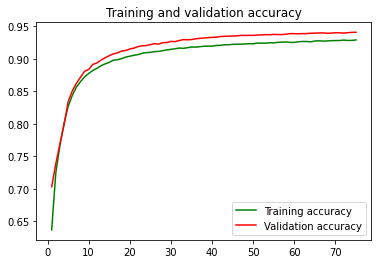

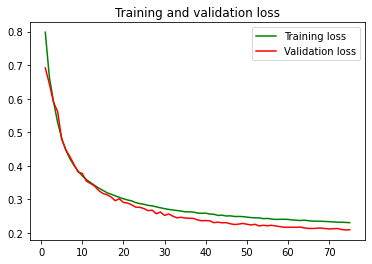

In [170]:
# Plot results
acc = model_history.history["accuracy"]
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Model Evaluation

In [171]:
print('Hasil Performa dengan Layers Embedding :')
print('\n',model_Emdedding_results)

Hasil Performa dengan Layers Embedding :

 {'accuracy': 94.08077005043688, 'precision': 0.9423329304184684, 'recall': 0.9408077005043688, 'f1': 0.9400704389663054}


# Data Inference

#### membuat data baru

In [172]:
new_tweets = [
            "Japanese nationalists are targeting their own medals",
            "The Indian mens hockey team beat current Olympycs",
            "Wales wins its firstever Olympic gold after 20 years"
]

#### melakukan prediksi terhadap data baru

In [173]:
predict = model.predict(new_tweets)
predict.argmax(axis=1)

array([0, 0, 2])

dari hasil prediksi dengan menggunakan data baru didapatkan hasil sebagai berikut:
* tweet pertama termasuk kedalam label tweet Netral
* tweet kedua termasuk kedalam label tweet Netral
* tweet ketiga termasuk kedalam label tweet Positive